In [15]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import offline, iplot, init_notebook_mode
import plotly.io as pio

#import pyspark
#from pyspark.sql.functions import lit
sb.set()

pd.set_option('display.max_rows', None)

In [16]:
init_notebook_mode(connected=True)

In [2]:
baseDF = pd.read_csv("movies.csv")
baseDF=baseDF.dropna(subset=['budget','gross'])
grossCOL = pd.DataFrame((baseDF["gross"]-baseDF["budget"]-baseDF["budget"]*0.5)>0)
baseDF["Success"] = grossCOL

In [3]:
kMeansVar = baseDF[["budget", "votes", "score", "Success"]]

#scaler = MinMaxScaler()
#scaled_features = scaler.fit_transform(kMeansVar[["budget", "votes", "score"]])
#scaled_features = pd.DataFrame(scaled_features, index=kMeansVar.index, columns=["budget", "votes", "score"])
#kMeansVar = scaled_features.assign(Success=kMeansVar["Success"])

print(kMeansVar.head())

       budget      votes  score  Success
0  19000000.0   927000.0    8.4     True
1   4500000.0    65000.0    5.8     True
2  18000000.0  1200000.0    8.7     True
3   3500000.0   221000.0    7.7     True
4   6000000.0   108000.0    7.3     True


Now, we will try to use K-Means Clustering to identify clusters in the dataset. 

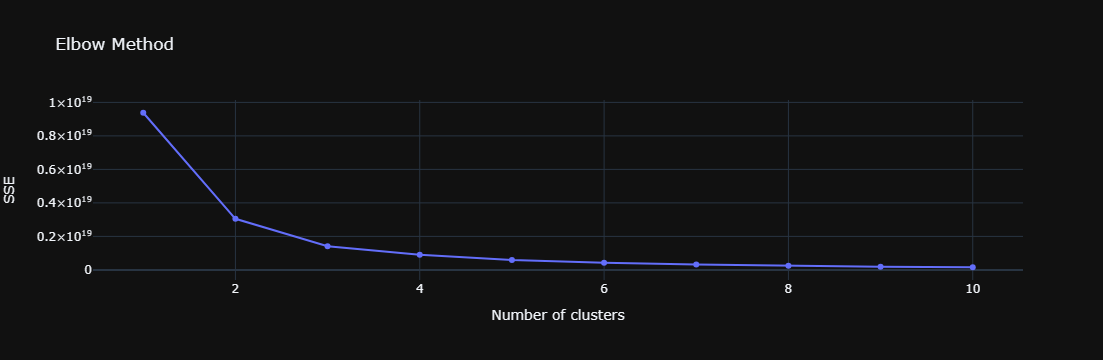

Best number of clusters: 3
Silhouette Score: 0.5591348038451258


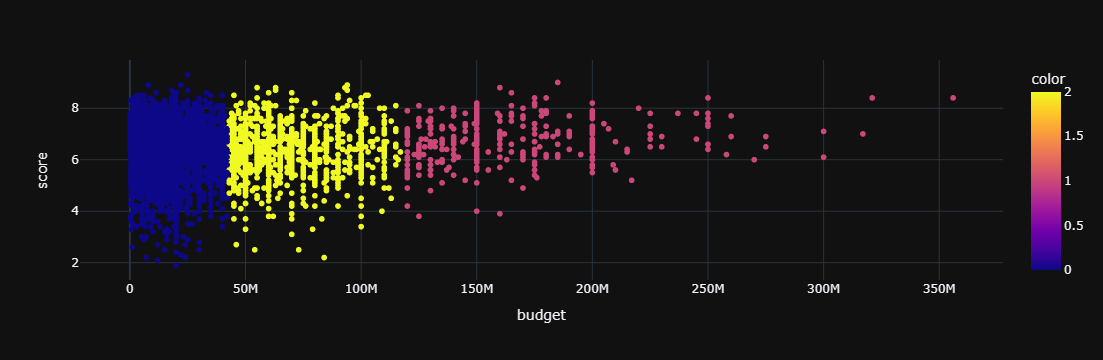

In [17]:
#Using the elbow method to determine the number of clusters to identify
sse = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", n_init= 50, max_iter=500, random_state=42)
    kmeans.fit(kMeansVar)
    sse.append(kmeans.inertia_)

f=px.line(x=range(1,11), 
          y=sse, 
          title="Elbow Method",
          labels={"y": "SSE", "x": "Number of clusters"},
          markers=True, 
          template="plotly_dark")
f.show()

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("Best number of clusters: {}".format(kl.elbow))

#Determining the silhouette score
print("Silhouette Score: {}".format(silhouette_score(kMeansVar, kmeans.labels_))) 

#Showing the clustering
kmeans = KMeans(n_clusters=3, init="k-means++", n_init= 50, max_iter=500, random_state=42)
kmeans.fit(kMeansVar)

f = px.scatter(kMeansVar, 
               x="budget", 
               y="score", 
               color=kmeans.labels_, 
               template="plotly_dark")
f.show()
print()

As seen from above, after using the Elbow method, it can be seen that the best number of cluster is 3 as that is the turning points. Silhouette coefficient values indicates whether the samples are closer to their clusters than they are to other clusters. The silhouette value ranges between -1 and 1. The silhouette value calculated is at 0.0.559, which is rather high and hence, the clusters are generally well separated. 

However, for our specific problem, we have already identified 2 main clusters - Success and Failure. Hence, due to the fact that we have ground truth values, it will be better if we used them as the clusters instead, and use Adjusted Rand Index as the indicator. 

In [20]:
#Using Success and Failure as the clusters
sb.set_style ("darkgrid")

kmeans = KMeans(n_clusters=2, init="k-means++", n_init= 50, max_iter=500, random_state=42)
kmeans.fit(kMeansVar)

f = px.scatter_3d(kMeansVar, 
                  x="budget",
                  y="votes",
                  z="score",
                  symbol="Success",
                  color=kmeans.labels_,
                  color_continuous_scale="oryel",
                  opacity=0.7,
                  title="K-Means",
                  template="plotly_dark")
f.update_layout(margin=dict(l=0, r=0, b=0, t=0), coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside", ticksuffix=" bills"))
f.show()

f = px.scatter_3d(kMeansVar, 
                  x="budget",
                  y="votes",
                  z="score",
                  color="Success",
                  color_discrete_sequence=["#FF0000", "#FFFFE0"],
                  opacity=0.7,
                  title="Ground Truth Values",
                  template="plotly_dark")
f.update_layout(margin=dict(l=0, r=0, b=0, t=0))
f.show()

print("Adjusted Rand Index: {}".format(adjusted_rand_score(kMeansVar["Success"], kmeans.labels_)))

"""
#3D Subplots
f = make_subplots(rows=1, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}]])
f.add_trace(go.Scatter3d(x=kMeansVar["budget"], 
                         y=kMeansVar["votes"], 
                         z=kMeansVar["score"], 
                         mode="markers",
                         marker=dict(size=12, color=kmeans.labels_, opacity=0.7)
                         ), 
            row=1, col=1)
f.add_trace(go.Scatter3d(x=kMeansVar["budget"], 
                         y=kMeansVar["votes"], 
                         z=kMeansVar["score"], 
                         mode="markers",
                         marker=dict(size=12, color=kMeansVar["Success"], opacity=0.7)
                         ), 
            row=1, col=2)
f.show()

#3D Plots
f = plt.figure(figsize = (24, 18))
axes = f.add_subplot(121, projection = "3d")
axes.scatter(kMeansVar["budget"], kMeansVar["votes"], kMeansVar["score"], c=["r" if i==1 else "b" for i in kmeans.labels_])
axes.set_title("K-Means")
axes.set_xlabel("budget")
axes.set_ylabel("votes")
axes.set_zlabel("score")

axes = f.add_subplot(122, projection = "3d")
axes.scatter(kMeansVar["budget"], kMeansVar["votes"], kMeansVar["score"], c=["r" if i==1 else "b" for i in kMeansVar["Success"]])
axes.set_title("Ground Truth Values")
axes.set_xlabel("budget")
axes.set_ylabel("votes")
axes.set_zlabel("score")

#2D Plots
kMeansVar = kMeansVar.assign(predicted_cluster=kmeans.labels_)
f, axes = plt.subplots(1, 3, figsize=(16, 12))
#plt.axis([0, 200000000, 0, 500000000])
sb.scatterplot(x="budget", y="gross", data=kMeansVar, s=50, hue="predicted_cluster", style="Success", ax=axes[0])
sb.scatterplot(x="votes", y="gross", data=kMeansVar, s=50, hue="predicted_cluster", style="Success", ax=axes[1])
sb.scatterplot(x="score", y="gross", data=kMeansVar, s=50, hue="predicted_cluster", style="Success", ax=axes[2])
"""
print()

Adjusted Rand Index: -0.009071240063742646



The Adjusted Rand Index (ARI) is a measure of the similarity between two true and predicted clusterings. The ARI output values range between -1 and 1. A score close to 0.0 indicates random agreement, and a score close to 1 indicates perfectly labeled clusters. Since ARI is at -0.00907, it seems that the data is not clustered well. Hence, it's hard to use kmeans as a model to cluster success because the success was already predefinied by 2 variables and kmeans predicts based on 4. Therefore, in the future, it might be better to define more clusters, or use more variables to determine success. 